In [25]:
%matplotlib inline
import warnings
import cv2 as cv
from PIL import Image, ImageFilter, ImageChops
from skimage.io import imread, imshow
import math
from scipy.ndimage.filters import median_filter
from skimage import img_as_float, img_as_ubyte
import matplotlib.pyplot as plt
import random
import numpy as np
warnings.filterwarnings('ignore')

### Задание 1
* Используя стандартные функции постройте гистограмму яркостей изображения. 
* Примените к изображению операцию «робастное линейное растяжение яркости» (в качестве порога возьмите 5-10% в зависимости от   изображения).
* Включите в отчёт гистограмму, исходное и обработанные изображения, карту разности.
* Картой разности двух изображений называем изображение, в котором яркость пикселей - это модуль разности между изображениями, т.е. * карта разницы - это изображение, на котором показана разница между двумя изображениями.


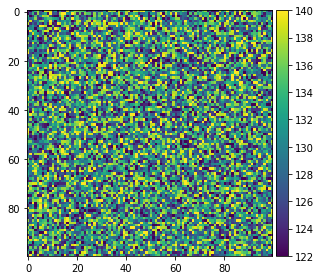

In [26]:
a = np.array([[0 for i in range(100) ] for j in range(100)])
for i in range(100):
    for j in range(100):
        a[i, j] = random.randint(122, 140)
imshow(a)

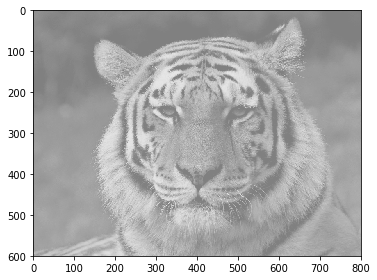

In [27]:
# Считываем картинку
img = imread('tiger-low-contrast.png')
imshow(a)

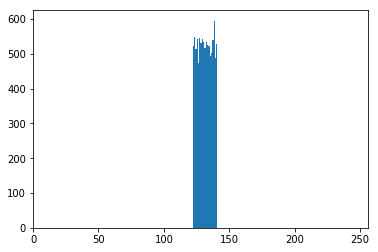

In [33]:
# Посмотрим на гистограмму изображения
plt.hist(a.ravel(), bins=range(257))
plt.xlim([0, 256])
plt.show()

In [34]:
# Карта разности
def map_difference(img1, img2):
    imshow(img_as_ubyte(np.abs(img_as_float(img1) - img_as_float(img2))))
    

# Генерация состыкованного исходного и обработанного изображения по вертикали
def join_img(img1, img2):
    height, width = img.shape[0], img.shape[1]
    new_img = np.zeros_like(img1)
    new_img[:, :(width//2 + 1), :] = img1[:, :(width//2 + 1), :]
    new_img[:, (width//2 + 1):, :] = img2[:, (width//2 + 1):, :]
    imshow(new_img)


# Линейное растяжение
def linear_tension(img):
    k = round(img.size * 0.05)
    values, _, = np.histogram(img.ravel(), bins=range(257))
    count = 0
    # Отбрасываем 5% самых больших и самых маленьких значений
    for i in range(len(values)):
        count += values[i]
        values[i] = 0
        if count > k:
            break
    count = 0
    for i in range(len(values) - 1, -1, -1):
        count += values[i]
        values[i] = 0
        if count > k:
            break
    for i in range(len(values)):
        if values[i] != 0:
            min_x = i - 1
            break
    for i in range(len(values) - 1, -1, -1):
        if values[i] != 0:
            max_x = i + 1
            break
    # Функция линейного выравнивания
    img = img.astype('float')
    img = (img - min_x) * (255 / (max_x - min_x))
    img = np.clip(img, 0, 255)
    return img.astype('uint8')

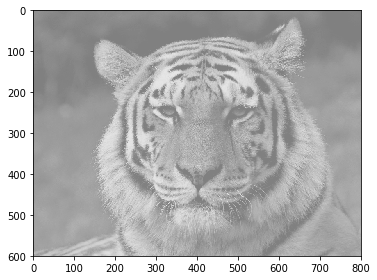

In [35]:
# Посмотрим на полученный результат
new_img = linear_tension(a)
imshow(img)

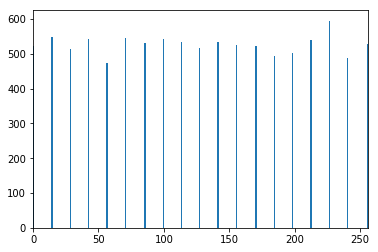

In [36]:
# Гистограмма нового изображения
plt.hist(new_img.ravel(), bins=range(257))
plt.xlim([0, 256])
plt.show()

In [32]:
# Карта разностси
map_difference(a, new_img)

ValueError: operands could not be broadcast together with shapes (100,100) (600,800) 

### Задание 2
* Примените операции «линейное растяжение по каналам» и «серый мир» к изображению.
* Операцию «серый мир» нужно реализовать самостоятельно.
* Включите в отчёт код и состыкованное изображение результатов применения операций.

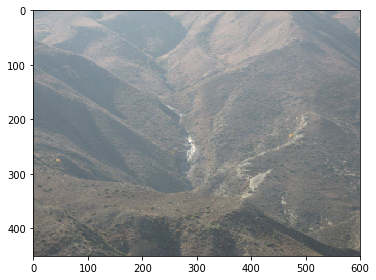

In [66]:
img = imread('img2.jpg')
imshow(img)

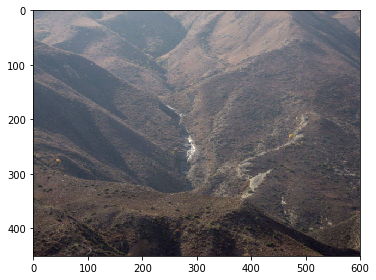

In [67]:
# Применим операцию линейное растяжение по каналам к нашему изображению
def channel_linear_stretching(img):
    img = img
    r = img[:, :, 0]
    g = img[:, :, 1]
    b = img[:, :, 2]
    max_x, min_x = r.max(), r.min()
    r = np.uint8((r - min_x) * (255 / (max_x - min_x)))
    max_x, min_x = g.max(), g.min()
    g = np.uint8((g - min_x) * (255 / (max_x - min_x)))
    max_x, min_x = b.max(), b.min()
    b = np.uint8((b - min_x) * (255 / (max_x - min_x)))
    return np.dstack((r, g, b))


new_img = channel_linear_stretching(img)
imshow(new_img)

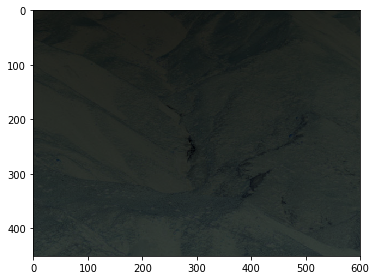

In [68]:
# Карта разности
map_difference(img, new_img)

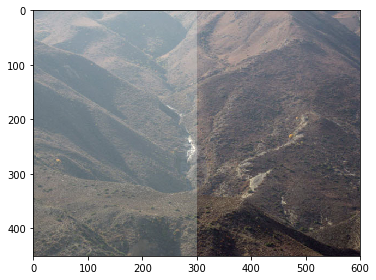

In [69]:
# Состыкованное изображение
join_img(img, new_img)

In [57]:
# Серый мир
def greyworld(img):
    avg = np.mean(img)
    r, g, b = np.mean(img[:, :, 0]) / avg, np.mean(img[:, :, 1]) / avg, np.mean(img[:, :, 2]) / avg
    new_r = np.clip(img[:, :, 0] / r, 0, 255)
    new_g = np.clip(img[:, :, 1] / g, 0, 255)
    new_b = np.clip(img[:, :, 2] / b, 0, 255)
    new_img = np.uint8(np.dstack((new_r, new_g, new_b)))
    return new_img

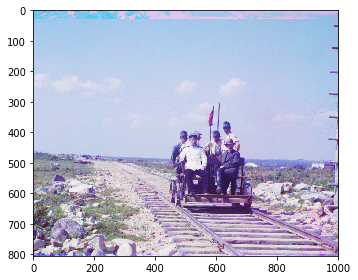

In [71]:
img = imread('img3.png')
imshow(img)

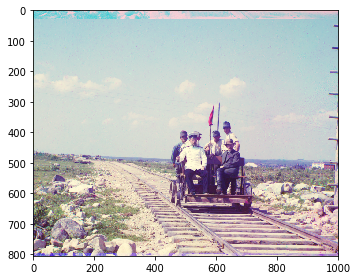

In [72]:
new_img = greyworld(img)
imshow(new_img)

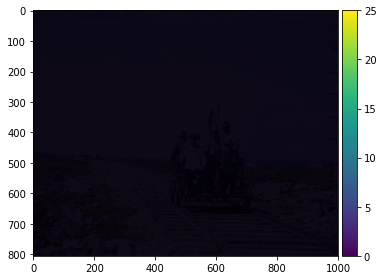

In [73]:
# Карта разности
map_difference(img, new_img)

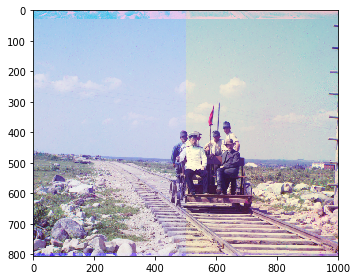

In [74]:
# Состыкованное изображение
join_img(img, new_img)

### Задание 3
* Зашумите изображение шумом типа «соль и перец». Подавите шум медианным фильтром, попробуйте разные размеры фильтра.
* Постройте карты разницы между исходным и зашумленным изображениями, и между скорректированным и исходным.
* Подумайте над способами получения этой разницы.
* В отчёт вставьте состыкованные исходное/обработанное изображения и карты разницы

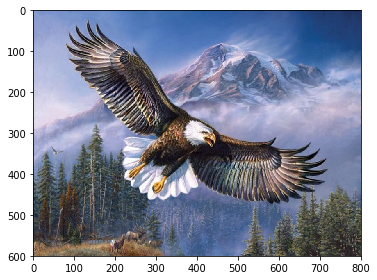

In [80]:
# Функция добавления шума на изображение
def salt_pepper(img, n):
    height, width = img.shape[0], img.shape[1]
    for i in range(n):
        h = random.randint(0, height - 1)
        w = random.randint(0, width - 1)
        img[h, w] = (255, 255, 255)
        h = random.randint(0, height - 1)
        w = random.randint(0, width - 1)
        img[h, w] = (0, 0, 0)
    return img

img = imread('img.jpg')
imshow(img)

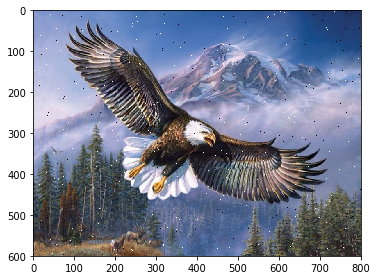

In [81]:
img_noise = salt_pepper(img, 1000)
imshow(img_noise)

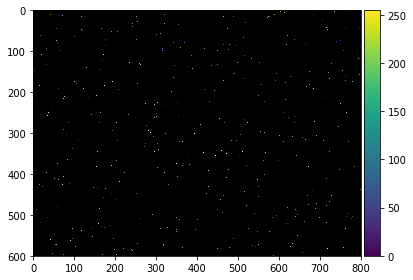

In [82]:
# Карта разности между исходным изображением и зашумленным
img = imread('img.jpg')
map_difference(img_noise, img)

In [83]:
# Медианный фильтр
def median_filter(img, n):
    height, width = img.shape[0], img.shape[1]
    value = n // 2
    coordinates = [[(i, j) for j in range(-value, value + 1)] for i in range(-value, value + 1)]
    new_img = img.copy()
    for i in range(height):
        for j in range(width):
            array = []
            for x in range(n):
                for y in range(n):
                    if (i + coordinates[x][y][0] >= 0) and (i + coordinates[x][y][0] < height) and (j + coordinates[x][y][1] >= 0) and (j + coordinates[x][y][1] < width):
                        array.append(img[i + coordinates[x][y][0], j + coordinates[x][y][1]])
                    else:
                        pass
            array.sort()
            if len(array) % 2 == 0:
                new_img[i, j] = round((array[len(array) // 2] + array[(len(array) // 2) - 1]) / 2)
            else:
                new_img[i, j] = array[len(array) // 2]
    return new_img                 
                        
    
    
    
    

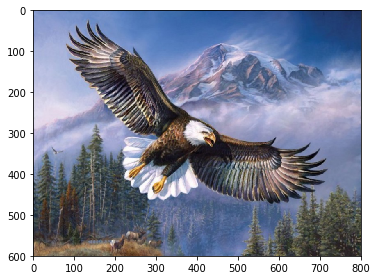

In [84]:
# Применяем медианный фильтр
new_img = np.dstack((median_filter(img_noise[:, :, 0], 3), median_filter(img_noise[:, :, 1], 3), median_filter(img_noise[:, :, 2], 3)))
imshow(new_img)

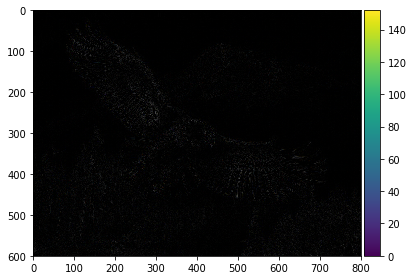

In [85]:
# Карта разности между исходным изображением и скорректированным
map_difference(img, new_img)

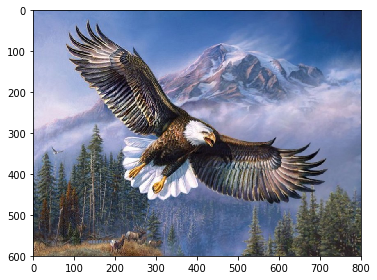

In [86]:
# Состыкованное изображение
join_img(img, new_img)

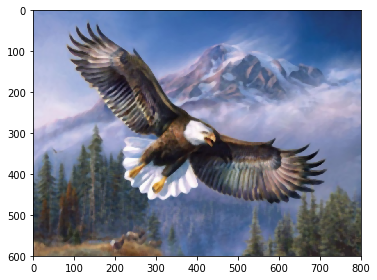

In [87]:
new_img = np.dstack((median_filter(img_noise[:, :, 0], 7), median_filter(img_noise[:, :, 1], 7), median_filter(img_noise[:, :, 2], 7)))
imshow(new_img)

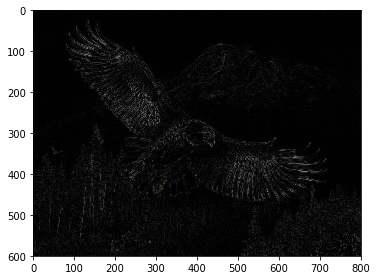

In [88]:
# Карта разности между исходным изображением и скорректированным
map_difference(img, new_img)

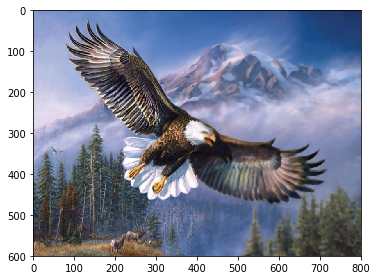

In [89]:
# Состыкованное изображение
join_img(img, new_img)

### Задание 4
* Самостоятельно напишите код для операции свёртки. Примените к изображению свёртки четырьмя разными фильтрами размера 3x3: «усреднение», «сдвиг на 1», «гауссов», «повышение резкости». Для этого подберите разные ядра фильтра.
* Сравните результат работы собственного фильтра со встроенными функциями, для этого постройте карты разницы изображений.
* Включите в отчёт исходное и обработанные изображения, карты разности.


In [3]:
# Дополнение изображения рамкой зеркальных пикселей
def refect_across_edge(img, n):
    k = n // 2
    new_img = img.copy()
    new_img = np.hstack((new_img, np.flip(new_img[:, -k:], 1)))
    new_img = np.hstack((np.flip(new_img[:, :k], 1), new_img))
    new_img = np.vstack((new_img, np.flip(new_img[-k:, :], 0)))
    new_img = np.vstack((np.flip(new_img[:k, :], 0), new_img))
    return new_img

# Дополнение изображения нулями
def img_add_zeros(image, n):
    temp_img = np.zeros((image.shape[0] + (n-1), image.shape[1] + (n-1)))
    temp_img[(n//2):-(n//2), (n//2):-(n//2)] = image
    return temp_img


# Свертка
def convolution(img, kernel, flag=True):
    n = len(kernel)
    height, width = img.shape[0], img.shape[1]
    new_img = np.zeros_like(img)
    if flag:
        img = np.dstack((refect_across_edge(img[:, :, 0], n), refect_across_edge(img[:, :, 1], n), refect_across_edge(img[:, :, 2], n)))
    else:
        img = np.dstack((img_add_zeros(img[:, :, 0], n), img_add_zeros(img[:, :, 1], n), img_add_zeros(img[:, :, 2], n)))
    for i in range(height):     
        for j in range(width):
            for k in range(3):
                new_img[i, j, k] = np.clip((kernel * img[i:i+n, j:j+n, k]).sum(), 0, 255)
    return new_img


# Фильтр Гаусса
def gaussian(sigma, x, y):
    return (1 / (2 * np.pi * sigma ** 2)) * np.e ** ((-x ** 2 - y ** 2) / (2 * sigma ** 2))



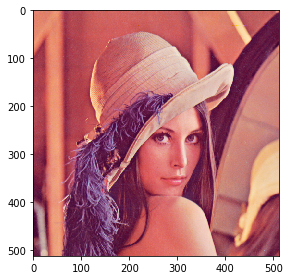

In [4]:
img = imread('Lenna.png')
img1 = Image.open('Lenna.png')
imshow(img)

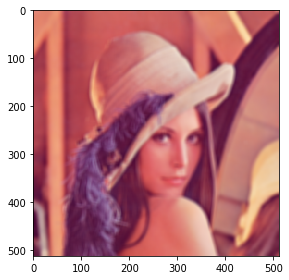

In [56]:
# Сдвиг на
kernel = [[0, 0, 0], [1, 0, 0], [0, 0, 0]]
new_img = convolution(new_img, kernel)
imshow(new_img)

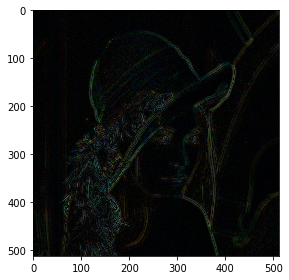

In [57]:
offsetlib = ImageChops.offset(img1, 1, 0)
map_difference(offsetlib, new_img)

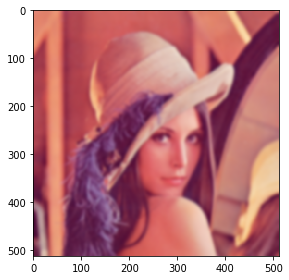

In [58]:
# Фильтр Гаусса
kernel = np.array([[gaussian(3, x, y) for x in range(-9, 10)] for y in range(-9, 10)])
s = sum(sum(kernel))
kernel = kernel / s
new_img = convolution(img, kernel)
imshow(new_img)

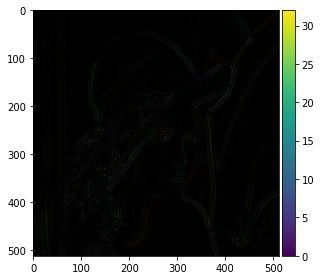

In [59]:
img1 = Image.open('Lenna.png')
gausslib = img1.filter(ImageFilter.GaussianBlur) 
map_difference(gausslib, new_img)

[[ 0.   -0.25  0.  ]
 [-0.25  2.   -0.25]
 [ 0.   -0.25  0.  ]]


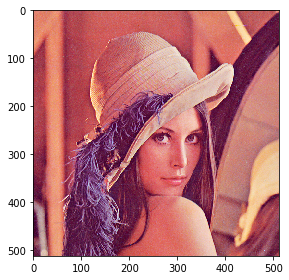

In [5]:
# Увеличение резкости
kernel = np.array([[0,-2,0],[-2,16,-2],[0,-2,0]]) * 1/8
print(kernel)
new_img = convolution(img, kernel)
imshow(new_img)

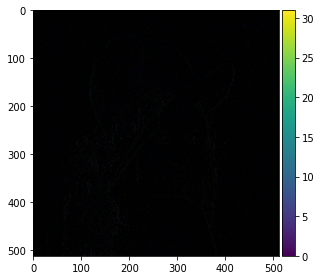

In [8]:
sharplib = img1.filter(ImageFilter.SHARPEN) 
map_difference(sharplib, new_img)

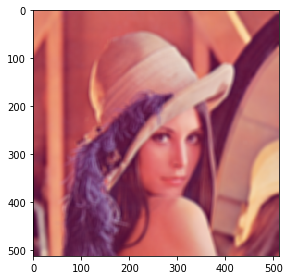

In [62]:
# Усреднение
kernel = np.array([[1/81 for i in range(9)] for j in range(9)])
new_img = convolution(img, kernel)
imshow(new_img)

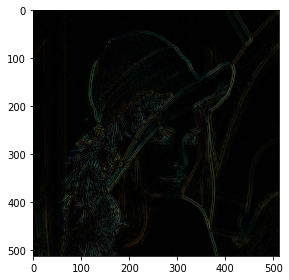

In [63]:
avlib = img1.filter(ImageFilter.SMOOTH) 
map_difference(avlib, new_img)

### Задание 5
* Реализуйте повышение резкости с помощью гауссова фильтра с разными размерами ядра и разными дисперсиями (“unsharp mask”). Сравните результат применения “unsharp mask” и фильтра для повышения резкости.
* Включите в отчёт исходное и обработанные изображения, карты разности.


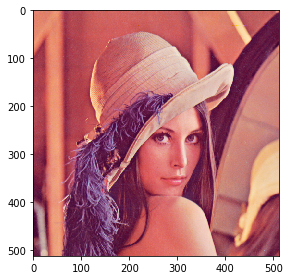

In [208]:
img = imread('Lenna.png')
imshow(img)

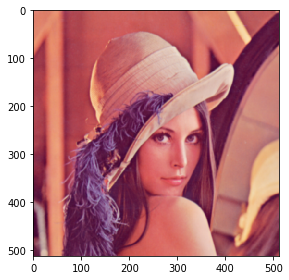

In [226]:
# Применим фильтр Гаусса с сигмой 1, ядром 5 на 5
kernel = np.array([[gaussian(1, x, y) for x in range(-2, 3)] for y in range(-2, 3)])
kernel = kernel / s
new_img = convolution(img, kernel)
imshow(new_img)

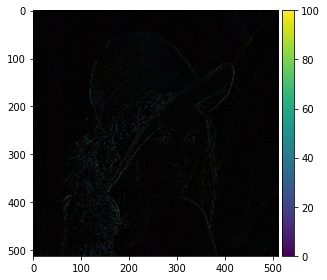

In [227]:
# Разность исходного изображения и получившегося
map_difference(img, new_img)

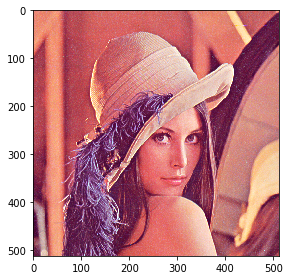

In [211]:
# Добавим разность к исходному изображению
img_diff = np.clip(img_as_float(img) - img_as_float(new_img), 0, 1)
res = img_as_ubyte(np.clip(img_as_float(img) + img_diff * 2, 0, 1))
imshow(res)

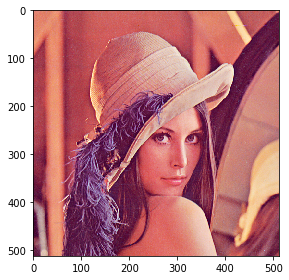

In [229]:
# Применим GaussianBlur к изображению и найдем unsharp_image
gaussian_3 = cv.GaussianBlur(img, (5,5), 2.0)
unsharp_image = cv.addWeighted(img, 1.5, gaussian_3, -0.5, 0)
imshow(unsharp_image)

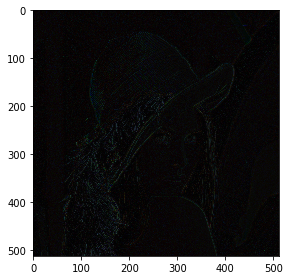

In [225]:
# Разница между unsharp_image и res
map_difference(unsharp_image, res)

### Вывод:
    1) Исходное изображение мало контрастное, оно имеет распределение пикселей не на всем диапозоне (128-229). После применения 
    робастного линейного растяжения яркости, изображение принимает более привычный. После построения гистограммы восстановленного 
    изображения, мы видим, что гистограмма получилась гребенчитой. 
     
    2) Исходные изображения имеют немного не естественный вид. После применения линейного растяжения по каналам и операции серый мир 
    мы видим, что изображения принимают более естественные цвета
    
    3) При подавлении шума с использованием разного размера медианного фильтра получаем разные результаты. Фильтр размера 3 справляется 
    отлично, шум полностью исчезает, картинка практически не изменяется. Фильтр размером 7 тоже полностью убирает шум, однако 
    изображение становится слишком размытым. При небольшом количестве шума, Фильтр размером 3 справится хорошо, однако, если количество 
    шумовых пикселей будет большим, тогда для достижения результата, нужно использовать больший размер фильтра.


    4) К исходному изображению я применял различные ядра. Чем больше ядро, тем больше заметна разница с исходным изображением. Если 
    сумма элементов ядра больше 1, только изображение становится светлее, если меньше 1, тогда темнее. Если сумма элементов 
    ядра равна 1, тогда изображение ме меняется в яркости.

    5) Фильтр повышения резкости и unsharp mask выдают похожий результат. При подборе параметра альфа, карта разницы между 
    изображениями, обработанными разными способами будет минимальна.


end